# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Итак, нам необходимо обучить модель предсказания стоимсоти автомобиля для привлечения новых клиентов. Так же следует учитывать, что заказчика не только интересует качество предсказания, но так же и скорость.

Для решения задачи, первым делом необходимо будет изучить данные и провести их предобработку для того, чтобы полученная модель давала наиболее качественные предсказания. Затем обучим несколько разных типов моделей и выберем лучшую из них по метрике RMSE (по заданию не менее 2500) на тестовой выборке с учетом требований заказчика по скорости обучения и предсказания.

Импортируем необходимый для работы библиотеки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import OrdinalEncoder 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor





Загрузим данные.

In [ ]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Данных нереально много. Думаю перед началом предобработки есть смысл удалить часть столбцов, которые совершенно точно не помогут обучению, а будут только замедлять программу.

Думаю, можно смело удалить столбцы:
1. DateCrawled - дата скачивания анкеты из базы;
2. RegistrationMonth  - месяц регистрации автомобиля (в данных есть стобец "год регистрации");
3. DateCreated — дата создания анкеты;
4. LastSeen — дата последней активности пользователя

In [ ]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen'], axis=1)

Изучим содержимое данных

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
 10  NumberOfPictures  354369 non-null  int64 
 11  PostalCode        354369 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.4+ MB


Самая важная инофрмация содержется в столбце - "Цена", это целевой признак, с него и начнем. Посмотрим на распределение, чтобы определить аномальные значения.

<AxesSubplot:>

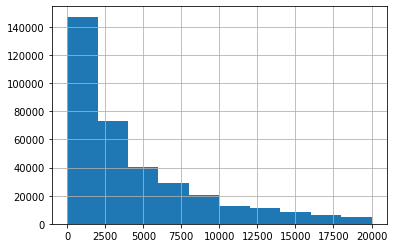

In [ ]:
data['Price'].hist()


Очеь много автомобилей с ценой близкой нулю. Посмотрим.

In [ ]:
data.query('Price == 0').count()

Price               10772
VehicleType          7032
RegistrationYear    10772
Gearbox              8294
Power               10772
Model                8588
Kilometer           10772
FuelType             7336
Brand               10772
NotRepaired          5484
NumberOfPictures    10772
PostalCode          10772
dtype: int64

Почти в одиннадцати тысячах объявлений не указана цена авто. Очевидно, это ошибка. В любом случае эти данные следует удалить, так как они исказять работу модели

In [ ]:
data.drop(data[data.Price == 0].index, inplace=True)

In [ ]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0,60437
...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,0,26624
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,0,39576
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,0,26135
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,0,87439


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343597 non-null  int64 
 1   VehicleType       309847 non-null  object
 2   RegistrationYear  343597 non-null  int64 
 3   Gearbox           326242 non-null  object
 4   Power             343597 non-null  int64 
 5   Model             326076 non-null  object
 6   Kilometer         343597 non-null  int64 
 7   FuelType          314138 non-null  object
 8   Brand             343597 non-null  object
 9   NotRepaired       277731 non-null  object
 10  NumberOfPictures  343597 non-null  int64 
 11  PostalCode        343597 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 34.1+ MB


Что касается типа авто и типа коробки. Имеются пропуски, которые невозможно заполнить данными. Не хочу, чтобы в информативной таблице маячили лишние пропуски, поэтому заполню их как неизвестный тип. 

In [ ]:
data['VehicleType'] = data['VehicleType'].fillna('unknown_type')
data['Gearbox'] = data['Gearbox'].fillna('unknown_gear')

И посмотрим, что получилось

<AxesSubplot:xlabel='VehicleType', ylabel='count'>

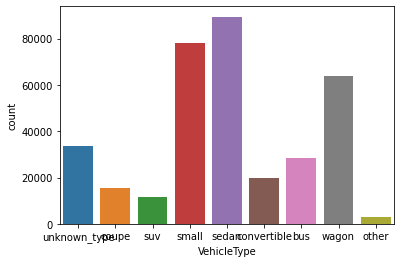

In [ ]:
sns.countplot(data.VehicleType)


<AxesSubplot:xlabel='Gearbox', ylabel='count'>

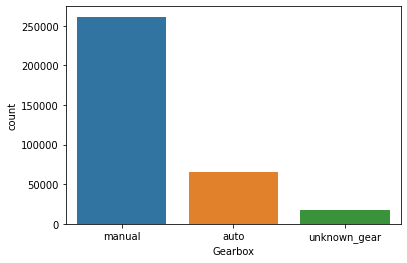

In [ ]:
sns.countplot(data.Gearbox)


Следующий на мой взгляд важный столбец, который  имеет прямое влияние на ценообразование, - мощность.

(0.0, 1000.0)

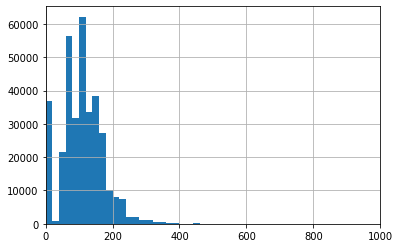

In [ ]:
data['Power'].hist(bins = 1000)
plt.xlim(0, 1000)


И снова у нас имеются транспортные средства с околонулевой мощностью. Посмотрим количество

In [ ]:
data.query('Power == 0').count()

Price               36360
VehicleType         36360
RegistrationYear    36360
Gearbox             36360
Power               36360
Model               31333
Kilometer           36360
FuelType            26730
Brand               36360
NotRepaired         17688
NumberOfPictures    36360
PostalCode          36360
dtype: int64

В более чем 36 тысячах объявлении указана нулевая мощность. Достаточно большой объем данных, который мы никак не сможем заполнить. Была мысль заполнить пропуски по средней мощности авто схожих моделей, но этот подход явно ошибочный, так как мощность может значительно варьироваться даже среди авто одной марки. Нет другого выхода кроме как удалить данные.

In [ ]:
data.drop(data[data.Power == 0].index, inplace=True)

Другой немаловажный показатель для определения стоимости авто - пробег. Посмотрим

<AxesSubplot:>

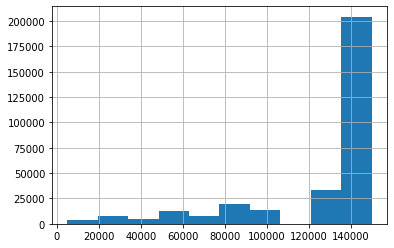

In [ ]:
data['Kilometer'].hist()


В этом столбце все норм, можно не менять.Хотя кажется немного странным, что нет данных о пробегах более 150000. Возможно, при регистрации объявлений, это максимальная опция по пробегу.

Столбцы Brand и Model также содержат пропуски. Восстановить данные не вижу возможности, поэтому заполним их как неизвестные. 

In [ ]:
data['Brand'] = data['Brand'].fillna('unknown_brand')


In [ ]:
data['Model'] = data['Model'].fillna('unknown_model')


Еще один немаловажный фактор для определения цены - это наличие ремонта. 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307237 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             307237 non-null  int64 
 1   VehicleType       307237 non-null  object
 2   RegistrationYear  307237 non-null  int64 
 3   Gearbox           307237 non-null  object
 4   Power             307237 non-null  int64 
 5   Model             307237 non-null  object
 6   Kilometer         307237 non-null  int64 
 7   FuelType          287408 non-null  object
 8   Brand             307237 non-null  object
 9   NotRepaired       260043 non-null  object
 10  NumberOfPictures  307237 non-null  int64 
 11  PostalCode        307237 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 30.5+ MB


Более сорока тысяч пропусков. Игнорировать не можем, удалять темболее. Так же заменим на неизвестно.

<AxesSubplot:xlabel='NotRepaired', ylabel='count'>

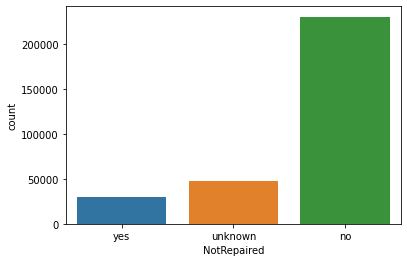

In [ ]:
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')
sns.countplot(data.NotRepaired)


И осталось посмотреть тип топлива.

<AxesSubplot:xlabel='FuelType', ylabel='count'>

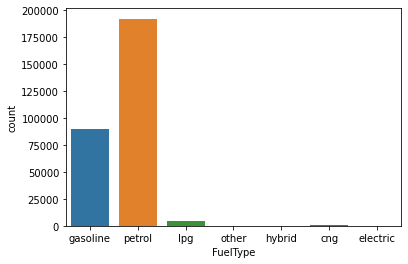

In [ ]:
sns.countplot(data.FuelType)


Если я не ошибаюсь, газолин и петрол это одно и тоже название бензина, крому того, судя по всему сюда также включили дизельное топливо. Думаю, можно объединить. Дополнительно, пропущенные значения заменим на неизвестное топливо

<AxesSubplot:xlabel='FuelType', ylabel='count'>

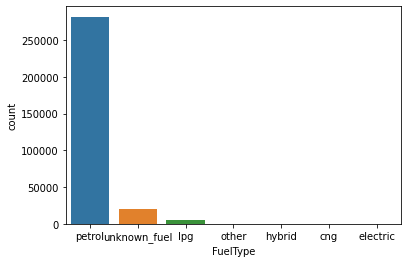

In [ ]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')
data['FuelType'] = data['FuelType'].fillna('unknown_fuel')

sns.countplot(data.FuelType)


Так как мы будем использовать все известные на данном этапе модели обучения, считаю необходимым заменить категоральные признаки на числовые.

In [ ]:
data2 = data.copy()

In [ ]:
data2

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
1,18300,coupe,2011,manual,190,unknown_model,125000,petrol,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown,0,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,0,60437
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,0,33775
...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknown_type,2016,auto,150,159,150000,unknown_fuel,alfa_romeo,no,0,51371
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,0,96465
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,0,26135
354367,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no,0,87439


In [ ]:
ord_enc = OrdinalEncoder()
data2['VehicleType'] = ord_enc.fit_transform(data2[['VehicleType']])
data2['Gearbox'] = ord_enc.fit_transform(data2[['Gearbox']])
data2['Model'] = ord_enc.fit_transform(data2[['Model']])
data2['FuelType'] = ord_enc.fit_transform(data2[['FuelType']])
data2['Brand'] = ord_enc.fit_transform(data2[['Brand']])
data2['NotRepaired'] = ord_enc.fit_transform(data2[['NotRepaired']])

In [ ]:
data2

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
1,18300,2.0,2011,1.0,190,227.0,125000,5.0,1.0,2.0,0,66954
2,9800,6.0,2004,0.0,163,117.0,125000,5.0,14.0,1.0,0,90480
3,1500,5.0,2001,1.0,75,116.0,150000,5.0,38.0,0.0,0,91074
4,3600,5.0,2008,1.0,69,101.0,90000,5.0,31.0,0.0,0,60437
5,650,4.0,1995,1.0,102,11.0,150000,5.0,2.0,2.0,0,33775
...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,7.0,2016,0.0,150,4.0,150000,6.0,0.0,0.0,0,51371
354362,3200,4.0,2004,1.0,225,140.0,150000,5.0,30.0,2.0,0,96465
354366,1199,1.0,2000,0.0,101,106.0,125000,5.0,32.0,0.0,0,26135
354367,9200,0.0,1996,1.0,102,223.0,150000,5.0,38.0,0.0,0,87439


Создадим отдельный фрейм для линейных моделей с прямым кодированием категоральных признаков

In [ ]:
data_ohe = pd.get_dummies(data, drop_first=True)
y_line = data_ohe['Price']
x_line = data_ohe.drop('Price', axis=1)
x_line_train, x_line_valid, y_line_train, y_line_valid = train_test_split(x_line, y_line, test_size = 0.25, random_state = 12345)
data_ohe

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
1,18300,2011,190,125000,0,66954,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,90480,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,91074,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,60437,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,33775,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,0,51371,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,0,96465,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,0,26135,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0,87439,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Можно переходить к обучению моделей

## Обучение моделей

### Дерево решений в регрессий

Разделим выборки на тренировочную, валидационную и тестовую в соотношении 3:1:1

In [ ]:
data_train, data_test = train_test_split(data2, test_size=0.20, random_state=12345)

In [ ]:
X = data_train.drop('Price',axis=1)
y = data_train['Price']
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 12345)


Подберем лучшие параметры

In [ ]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 50):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(x_train, y_train) 
    predictions_valid = model.predict(x_valid) 
    result =  mean_squared_error(y_valid, predictions_valid)**0.5 
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth)

RMSE наилучшей модели на валидационной выборке: 1950.581476127252 Глубина дерева: 13


Посчитаем время обучения и время предсказания. Для этих целей напишем две функции соответственно

In [ ]:
def learn_time(model, x_train, y_train):
    start_time = time.time()
    model.fit(x_train,y_train)
    finish_time = time.time()
    time_fit = finish_time - start_time
    return time_fit,model

In [ ]:
def predict_time(model, x_valid):
    start_time = time.time()
    predict = model.predict(x_valid)    
    finish_time = time.time()
    time_predict = finish_time - start_time
    return time_predict, model

In [ ]:
model_des_tr_reg = DecisionTreeRegressor(random_state=12345, max_depth=13)
model_des_tr_reg.fit(x_train, y_train) 

DecisionTreeRegressor(max_depth=13, random_state=12345)

In [ ]:
learn_time(model_des_tr_reg, x_train, y_train)

(0.586040735244751, DecisionTreeRegressor(max_depth=13, random_state=12345))

In [ ]:
predict_time(model_des_tr_reg, x_valid)

(0.011441230773925781, DecisionTreeRegressor(max_depth=13, random_state=12345))

Мы получили необходиымую метрику RMSE, время обучения 0,8446, предсказания 0,0145.

### Случайный лес

In [ ]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(x_train, y_train) 
        predictions_valid = model.predict(x_valid) 
        result = mean_squared_error(y_valid, predictions_valid)**0.5 
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

RMSE наилучшей модели на валидационной выборке: 1893.9517039730679 Количество деревьев: 50 Максимальная глубина: 10


In [ ]:
model_ran_for_reg = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=10) 
model_ran_for_reg.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345)

In [ ]:
learn_time(model_ran_for_reg, x_train, y_train)

(17.63904356956482,
 RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345))

In [ ]:
predict_time(model_ran_for_reg, x_valid)

(0.3088498115539551,
 RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345))

В этой модели мы так же получили необходимый показатель метрики RMSE, однако время обучения значительно больше чем у Дерева решений. Пока опустим эту модель.

### Линейная регрессия

In [ ]:
model_line = LinearRegression()
model_line.fit(x_line_train, y_line_train)
predictions_valid = model_line.predict(x_line_valid) 

result = mean_squared_error(y_line_valid, predictions_valid)**0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)

RMSE модели линейной регрессии на валидационной выборке: 3222.178652941222


Дополним картину измерением времени

In [ ]:
learn_time(model_line, x_line_train, y_line_train)

(19.204323053359985, LinearRegression())

In [ ]:
predict_time(model_line, x_line_valid)

(0.2391681671142578, LinearRegression())

### Градиентный бустинг

Для Градиентного бустинга не обязательно кодировать категоральные признаки. Однако, мы сделалу уже кодирование. Не вижу смысла перегружать исследование данными. Используем общий датафрейм с кодированными данными

In [ ]:
#cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
model_cat = CatBoostRegressor(n_estimators=100, silent=True)
model_cat.fit(x_train, y_train)
predictions_valid = model_cat.predict(x_valid) 

result = mean_squared_error(y_valid, predictions_valid)**0.5
print("RMSE модели на валидационной выборке:", result)

RMSE модели на валидационной выборке: 1713.2736785933064


In [ ]:
learn_time(model_cat, x_train, y_train)

(2.9475648403167725, <catboost.core.CatBoostRegressor at 0x7f9a75bba610>)

In [ ]:
predict_time(model_cat, x_valid)

(0.010980367660522461, <catboost.core.CatBoostRegressor at 0x7f9a75bba610>)

Отличное качество модели. 

### Lightgbm

Не смотря на то, что данный тип модели способен работать с категоральными данными, не вижу смысла откатывать датафрейм к изначальному. Так же используем уже кодированные данные

In [ ]:
model_LGMB = LGBMRegressor(random_state=12345)
model_LGMB.fit(x_train, y_train)

LGBMRegressor(random_state=12345)

In [ ]:
predict_LGMB = model_LGMB.predict(x_valid)
result_LGMB = mean_squared_error(y_valid, predict_LGMB)**0.5
print("RMSE модели  на валидационной выборке:", result_LGMB)

RMSE модели  на валидационной выборке: 1726.0901997240042


In [ ]:
learn_time(model_LGMB, x_train, y_train)

(4.1849706172943115, LGBMRegressor(random_state=12345))

In [ ]:
predict_time(model_LGMB, x_valid)

(0.49338483810424805, LGBMRegressor(random_state=12345))

Мы получили неплохой показатель метрики, однако время обучения немного больше, чему  дерева решений. Сравним показатели позже

## Анализ моделей

Мы обучили пять моделей и измерили их метрики RMSE, а также время их обучения и предсказания на валидационных выборках. Попробуем объединить данные в таблицу для наглядного анализа и сравнения.

In [ ]:
models = ['DecisionTreeRegressor', '1950.5815', '0.5828', '0.0122'], [
    'RandomForestRegressor', '1893.9517', '15.6985', '0.2833'], [
    'LinearRegression', '3222.1787', '19.4015', '0.2966'], [
    'CatBoostRegressor', '1713.2737', '2.9693', '0.0115'], [
    'LGBMRegressor', '1726.0901', '4.2027', '0.5083']
columns = ['type', 'RMSE', 'learn_time', 'predict_time']
final_models = pd.DataFrame(data=models , columns=columns)
final_models

,type,RMSE,learn_time,predict_time
0,DecisionTreeRegressor,1950.5815,0.5828,0.0122
1,RandomForestRegressor,1893.9517,15.6985,0.2833
2,LinearRegression,3222.1787,19.4015,0.2966
3,CatBoostRegressor,1713.2737,2.9693,0.0115
4,LGBMRegressor,1726.0901,4.2027,0.5083


Лучший показатель у модели CatBoostRegressor

Оценим важность признаков

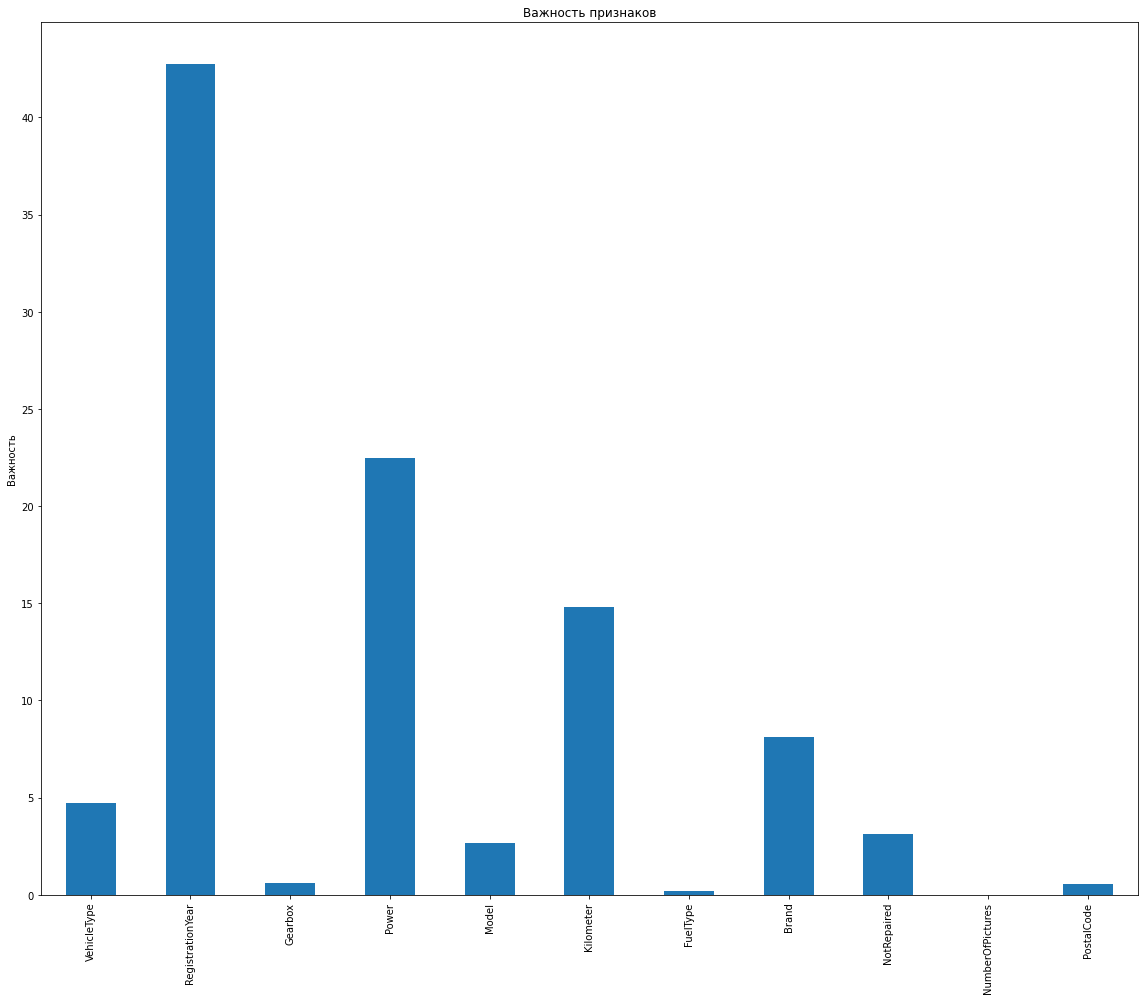

In [ ]:
importance = pd.Series(model_cat.feature_importances_,
                         data2.drop(['Price'], axis=1).columns)

fig, ax = plt.subplots(figsize=(16,14))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Самый важный фактор - это конечно же возраст, затем мощность и пробег. Странно только, что тип КПП имеет крайне низкую важность. 

### Проверка на валидационной выборке

In [ ]:
model_cat_test = CatBoostRegressor(n_estimators=100, silent=True)
model_cat_test.fit(x_train, y_train)

predictions_valid_cat_test = model_cat_test.predict(x_test) 

print("RMSE модели на валидационной выборке:", mean_squared_error(y_test, predictions_valid_cat_test)**0.5)
print('Время обучения:', learn_time(model_cat_test, x_train, y_train))
print('Время предсказания:', predict_time(model_cat_test, x_test))

RMSE модели на валидационной выборке: 1720.909418540015
Время обучения: (2.9865665435791016, <catboost.core.CatBoostRegressor object at 0x7f9a75bd0850>)
Время предсказания: (0.012626171112060547, <catboost.core.CatBoostRegressor object at 0x7f9a75bd0850>)


## Итог

Две модели обучения (LGBMRegressor и CatBoostRegressor) показали достаточно высокое качество предсказания при достаточно быстрой обработке данных. Однако CatBoostRegressor обучается немного быстрее и предсказует также быстрее, поэтому предложим заказчикуименно эту модель.